
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fblaura/FraudD/blob/main/AutoML/2_AutoML_for_dataset_passed_by_Normalization_and_SMOTE_imbalance_of_0_1.ipynb)

 **Please make sure to install the following libraries in order for the entire notebook to work.**

AutoML H20 is a process that assists in the selection of training models, which compares the performance of models by comparing metrics, which are then reflected in a leaderboard. In order to get an initial idea of which supervised or unsupervised models are ideal for our case (fraud detection) this type of training is used. The data used for this exercise is coded, preprocessed and passed through a technique to adjust the unequal distribution of the classes of the dataset, this technique is called SMOTE (Synthetic Minority Over-sampling Technique), as a rate to adjust the imbalance is chosen: **0.05**. Inside the folder you will find AutoML executions for different scaling methods and SMOTE rates. 


# **1. Libraries Installation**

In [ ]:
! pip install requests
! pip install tabulate
! pip install "colorama>=0.3.8"
! pip install future

In [ ]:
!pip install gdown

In [ ]:
! pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o


Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 175.8 MB 6.4 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.3-py2.py3-none-any.whl size=175832480 sha256=5d50beb07debf7c9fb758fe4814ffcdbe50beebe37a992a8132135a79893e241
  Stored in directory: /root/.cache/pip/wheels/2a/52/cf/01f6938288f0731963463ff72510db67f9f3076f801038b2f7
Successfully built h2o


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from pandas_profiling import ProfileReport
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Normalizer, StandardScaler
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, validation_curve  
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, roc_curve,precision_score,roc_auc_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import accuracy_score, roc_auc_score
from matplotlib.pylab import rcParams


In [3]:
from google.colab import files

# **2. h2o initialization**

In [ ]:
import h2o
from h2o.automl import H2OAutoML


In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcfmbwz4h
  JVM stdout: /tmp/tmpcfmbwz4h/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpcfmbwz4h/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_hidbhf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


# **3. Dataset initialization**

Due to the size of the dataset it is not possible to download the file from Github, as an alternative a link is used to download the dataset from Drive. ***Remember that this dataset is no longer a representation of the raw data due to its previous preprocessing.*** 

In [4]:
#train_fill
!gdown --id 1JPoAQMBKVeVOhmerYESaKXjVbGaz8zki

Downloading...
From: https://drive.google.com/uc?id=1JPoAQMBKVeVOhmerYESaKXjVbGaz8zki
To: /content/X_trainn_01.csv
100% 426M/426M [00:02<00:00, 152MB/s]


In [5]:
X_trainn_01 = pd.read_csv('/content/X_trainn_01.csv')

In [6]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

We can observe that the distribution of classes within the dataset being worked on is quite unbiased. We have that for the class representing the existence of 'No fraud' there is a presence of 90.9% of cases, while for the positive event 'Fraud' there are only 9.09% cases. This distribution of data is given after applying the SMOTE imbalance technique with a rate of 0.1. This shows the increased presence of fraud labels.

In [7]:
counting=X_trainn_01['isFraud'].value_counts().values
pieplot=pd.DataFrame([[counting[0], 'NoFraud'], [counting[1], 'Fraud']],columns=['Count of cases', 'Events'])

In [8]:
fig = px.pie(pieplot, values='Count of cases', names='Events', title='Distribution of imbalanced classes')
fig.show()

# **4. AutoML for dataset with Normalization scaling and imbalance with SMOTE 0.1**

The training process with AutoML is then initiated, the task is defined as a classification problem. The conversion from Pandas Dataframe to H2O dataframe is made in order to start the automatic process; the leaderboard and the best models are called. 

Different notebooks are created due to the RAM consumption generated by the conversion from Pandas to H20 driven by the volume of the dataset. Recall also that the original Kaggle competition dataset has approximately 590.000 rows, while this notebook works with a partition representing one eighth of the data. 

In [ ]:
hftrainn_01 = h2o.H2OFrame(X_trainn_01)
#hftest =h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
trainn_01, testnn_01 = hftrainn_01.split_frame(ratios=[.7]) #mirar en diferentes proporciones 70/30 ... 

In [ ]:
xnn_01 = trainn_01.columns
ynn_01 = "isFraud"
xnn_01.remove(ynn_01)

In [ ]:
trainn_01[ynn_01] = trainn_01[ynn_01].asfactor()


Run AutoML for 15 base models

In [ ]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_runtime_secs = 3600*5, max_models=15, seed=1) # tres horas, ir modificando el tiempo, trabajar con 10 modelos 
# ir mirando si se necesita aumentar más modelos
aml.train(x=xnn_01, y=ynn_01, training_frame=trainn_01)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_2_AutoML_1_20211010_164342,0.98683,0.043687,0.964167,0.0500279,0.0991658,0.00983386
StackedEnsemble_AllModels_3_AutoML_1_20211010_164342,0.986774,0.0437551,0.964066,0.0492517,0.0992328,0.00984714
StackedEnsemble_AllModels_6_AutoML_1_20211010_164342,0.986716,0.0438924,0.964083,0.049655,0.0994407,0.00988846
StackedEnsemble_AllModels_1_AutoML_1_20211010_164342,0.986703,0.0437807,0.964052,0.0492416,0.0992699,0.00985451
StackedEnsemble_BestOfFamily_3_AutoML_1_20211010_164342,0.986441,0.0443795,0.963801,0.0506224,0.0999311,0.00998623
StackedEnsemble_BestOfFamily_6_AutoML_1_20211010_164342,0.986438,0.0444636,0.963805,0.0502495,0.100058,0.0100116
StackedEnsemble_BestOfFamily_2_AutoML_1_20211010_164342,0.986412,0.0443616,0.963825,0.0508745,0.0998874,0.00997749
GBM_1_AutoML_1_20211010_164342,0.986393,0.0480708,0.96343,0.0501385,0.104314,0.0108815
StackedEnsemble_BestOfFamily_1_AutoML_1_20211010_164342,0.986276,0.0446848,0.963465,0.0494328,0.10025,0.0100501
StackedEnsemble_AllModels_5_AutoML_1_20211010_164342,0.985966,0.042921,0.963855,0.0470954,0.0962254,0.00925932


With the use of `extra_columns` is possible to obtain de timen information regarding each trained model



In [ ]:
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_2_AutoML_1_20211010_164342,0.98683,0.043687,0.964167,0.0500279,0.0991658,0.00983386,12078,0.168362,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211010_164342,0.986774,0.0437551,0.964066,0.0492517,0.0992328,0.00984714,11095,0.19247,StackedEnsemble
StackedEnsemble_AllModels_6_AutoML_1_20211010_164342,0.986716,0.0438924,0.964083,0.049655,0.0994407,0.00988846,154554,0.223246,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20211010_164342,0.986703,0.0437807,0.964052,0.0492416,0.0992699,0.00985451,11824,0.204069,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20211010_164342,0.986441,0.0443795,0.963801,0.0506224,0.0999311,0.00998623,8933,0.081231,StackedEnsemble
StackedEnsemble_BestOfFamily_6_AutoML_1_20211010_164342,0.986438,0.0444636,0.963805,0.0502495,0.100058,0.0100116,144401,0.07691,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20211010_164342,0.986412,0.0443616,0.963825,0.0508745,0.0998874,0.00997749,9699,0.076251,StackedEnsemble
GBM_1_AutoML_1_20211010_164342,0.986393,0.0480708,0.96343,0.0501385,0.104314,0.0108815,540587,0.081416,GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20211010_164342,0.986276,0.0446848,0.963465,0.0494328,0.10025,0.0100501,10927,0.078409,StackedEnsemble
StackedEnsemble_AllModels_5_AutoML_1_20211010_164342,0.985966,0.042921,0.963855,0.0470954,0.0962254,0.00925932,46574,0.475083,StackedEnsemble


And as well we can obtain information about the leader model

In [ ]:
# Get the best model using the metric
m = aml.leader
m

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_2_AutoML_1_20211010_164342

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0005764082826760133
RMSE: 0.024008504382322805
LogLoss: 0.007480351651564852
Null degrees of freedom: 9933
Residual degrees of freedom: 9929
Null deviance: 5941.497252933043
Residual deviance: 148.6196266132905
AIC: 158.6196266132905
AUC: 0.9999982410612934
AUCPR: 0.9999820417450695
Gini: 0.9999964821225868

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33075370195854126: 


,,0,1,Error,Rate
0,0,9054.0,1.0,0.0001,(1.0/9055.0)
1,1,1.0,878.0,0.0011,(1.0/879.0)
2,Total,9055.0,879.0,0.0002,(2.0/9934.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.330754,0.998862,118.0
1,max f2,0.330754,0.998862,118.0
2,max f0point5,0.475011,0.999087,114.0
3,max accuracy,0.330754,0.999799,118.0
4,max precision,0.999963,1.000000,0.0
5,max recall,0.194531,1.000000,129.0
6,max specificity,0.999963,1.000000,0.0
7,max absolute_mcc,0.330754,0.998752,118.0
8,max min_per_class_accuracy,0.330754,0.998862,118.0
9,max mean_per_class_accuracy,0.194531,0.999393,129.0



Gains/Lift Table: Avg response rate:  8.85 %, avg score:  9.31 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010066,0.999956,11.301479,11.301479,1.000000,0.999975,1.000000,0.999975,0.113766,0.113766,1030.147895,1030.147895,0.113766
1,2,0.020032,0.999898,11.301479,11.301479,1.000000,0.999929,1.000000,0.999952,0.112628,0.226394,1030.147895,1030.147895,0.226394
2,3,0.029998,0.999801,11.301479,11.301479,1.000000,0.999851,1.000000,0.999919,0.112628,0.339022,1030.147895,1030.147895,0.339022
3,4,0.040064,0.999637,11.301479,11.301479,1.000000,0.999728,1.000000,0.999871,0.113766,0.452787,1030.147895,1030.147895,0.452787
4,5,0.050030,0.999232,11.301479,11.301479,1.000000,0.999453,1.000000,0.999787,0.112628,0.565415,1030.147895,1030.147895,0.565415
5,6,0.100060,0.060262,8.686449,9.993964,0.768612,0.768377,0.884306,0.884082,0.434585,1.000000,768.644861,899.396378,0.987300
6,7,0.149990,0.019096,0.000000,6.667114,0.000000,0.031197,0.589933,0.600169,0.000000,1.000000,-100.000000,566.711409,0.932523
7,8,0.200020,0.012263,0.000000,4.999497,0.000000,0.015381,0.442375,0.453898,0.000000,1.000000,-100.000000,399.949673,0.877637
8,9,0.299980,0.006467,0.000000,3.333557,0.000000,0.008829,0.294966,0.305592,0.000000,1.000000,-100.000000,233.355705,0.767973
9,10,0.400040,0.003953,0.000000,2.499748,0.000000,0.005044,0.221188,0.230417,0.000000,1.000000,-100.000000,149.974836,0.658200




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.009833860223725926
RMSE: 0.09916582185272266
LogLoss: 0.04368700458057409
Null degrees of freedom: 54644
Residual degrees of freedom: 54639
Null deviance: 33264.136164777025
Residual deviance: 4774.552730610943
AIC: 4786.552730610943
AUC: 0.9868297675576931
AUCPR: 0.9641667885493395
Gini: 0.9736595351153863

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41469407496880073: 


,,0,1,Error,Rate
0,0,49530.0,154.0,0.0031,(154.0/49684.0)
1,1,481.0,4480.0,0.097,(481.0/4961.0)
2,Total,50011.0,4634.0,0.0116,(635.0/54645.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.414694,0.933820,158.0
1,max f2,0.179101,0.924975,225.0
2,max f0point5,0.722534,0.962680,95.0
3,max accuracy,0.418499,0.988380,157.0
4,max precision,0.999915,1.000000,0.0
5,max recall,0.000308,1.000000,398.0
6,max specificity,0.999915,1.000000,0.0
7,max absolute_mcc,0.414694,0.928106,158.0
8,max min_per_class_accuracy,0.046419,0.956586,302.0
9,max mean_per_class_accuracy,0.116014,0.962026,253.0



Gains/Lift Table: Avg response rate:  9.08 %, avg score:  9.08 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.999954,11.014916,11.014916,1.000000,0.999976,1.000000,0.999976,0.110260,0.110260,1001.491635,1001.491635,0.110260
1,2,0.020002,0.999885,11.014916,11.014916,1.000000,0.999924,1.000000,0.999950,0.110058,0.220318,1001.491635,1001.491635,0.220318
2,3,0.030012,0.999738,11.014916,11.014916,1.000000,0.999821,1.000000,0.999907,0.110260,0.330579,1001.491635,1001.491635,0.330579
3,4,0.040004,0.999435,11.014916,11.014916,1.000000,0.999603,1.000000,0.999831,0.110058,0.440637,1001.491635,1001.491635,0.440637
4,5,0.050014,0.998647,11.014916,11.014916,1.000000,0.999124,1.000000,0.999689,0.110260,0.550897,1001.491635,1001.491635,0.550897
5,6,0.100009,0.113738,7.785433,9.400470,0.706808,0.692647,0.853431,0.846196,0.389236,0.940133,678.543319,840.047024,0.924011
6,7,0.150005,0.028009,0.455595,6.419209,0.041362,0.053823,0.582774,0.582104,0.022778,0.962911,-54.440500,541.920890,0.894076
7,8,0.200000,0.015013,0.157241,4.853860,0.014275,0.020405,0.440662,0.441692,0.007861,0.970772,-84.275925,385.386011,0.847734
8,9,0.300009,0.007031,0.096746,3.268059,0.008783,0.010164,0.296694,0.297841,0.009675,0.980447,-90.325417,226.805863,0.748381
9,10,0.400000,0.004097,0.066525,2.467748,0.006040,0.005364,0.224037,0.224728,0.006652,0.987099,-93.347507,146.774844,0.645722


And for other models that may be of interest to us

In [ ]:
# Get the best XGBoost model using default sort metric
xgb = aml.get_best_model(algorithm="xgboost")
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_1_20211010_164342


Model Summary: 


,,number_of_trees
0,,96.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.002172109103233573
RMSE: 0.046605891293199975
LogLoss: 0.01195740243651461
Mean Per-Class Error: 0.003143746729684427
AUC: 0.9999579685884494
AUCPR: 0.9996218010356154
Gini: 0.9999159371768989

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2609417736530304: 


,,0,1,Error,Rate
0,0,49671.0,13.0,0.0003,(13.0/49684.0)
1,1,41.0,4920.0,0.0083,(41.0/4961.0)
2,Total,49712.0,4933.0,0.001,(54.0/54645.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.260942,0.994542,220.0
1,max f2,0.189661,0.993835,232.0
2,max f0point5,0.334011,0.996947,207.0
3,max accuracy,0.268324,0.999012,219.0
4,max precision,0.999902,1.000000,0.0
5,max recall,0.035969,1.000000,314.0
6,max specificity,0.999902,1.000000,0.0
7,max absolute_mcc,0.260942,0.994004,220.0
8,max min_per_class_accuracy,0.122247,0.996498,255.0
9,max mean_per_class_accuracy,0.183453,0.996856,234.0



Gains/Lift Table: Avg response rate:  9.08 %, avg score:  9.07 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010047,9.998919e-01,11.014916,11.014916,1.000000,0.999950,1.000000,0.999950,0.110663,0.110663,1001.491635,1001.491635,0.110663
1,2,0.020002,9.996576e-01,11.014916,11.014916,1.000000,0.999793,1.000000,0.999872,0.109655,0.220318,1001.491635,1001.491635,0.220318
2,3,0.030012,9.991888e-01,11.014916,11.014916,1.000000,0.999461,1.000000,0.999735,0.110260,0.330579,1001.491635,1001.491635,0.330579
3,4,0.040004,9.982506e-01,11.014916,11.014916,1.000000,0.998777,1.000000,0.999496,0.110058,0.440637,1001.491635,1001.491635,0.440637
4,5,0.050014,9.957070e-01,11.014916,11.014916,1.000000,0.997160,1.000000,0.999028,0.110260,0.550897,1001.491635,1001.491635,0.550897
5,6,0.100009,7.350721e-02,8.954659,9.984976,0.812958,0.739192,0.906496,0.869134,0.447692,0.998589,795.465930,898.497632,0.988304
6,7,0.150005,1.871841e-02,0.028223,6.666463,0.002562,0.034373,0.605221,0.590914,0.001411,1.000000,-97.177730,566.646334,0.934868
7,8,0.200000,9.890169e-03,0.000000,5.000000,0.000000,0.013581,0.453930,0.446594,0.000000,1.000000,-100.000000,400.000000,0.879881
8,9,0.300009,4.276873e-03,0.000000,3.333232,0.000000,0.006527,0.302611,0.299896,0.000000,1.000000,-100.000000,233.323167,0.769886
9,10,0.400000,2.317847e-03,0.000000,2.500000,0.000000,0.003177,0.226965,0.225723,0.000000,1.000000,-100.000000,150.000000,0.659911




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.012742492408406955
RMSE: 0.1128826488367763
LogLoss: 0.05714599634108102
Mean Per-Class Error: 0.04833860216280661
AUC: 0.9811873832380775
AUCPR: 0.9499063279919241
Gini: 0.962374766476155

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3048343241214752: 


,,0,1,Error,Rate
0,0,49475.0,209.0,0.0042,(209.0/49684.0)
1,1,608.0,4353.0,0.1226,(608.0/4961.0)
2,Total,50083.0,4562.0,0.015,(817.0/54645.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.304834,0.914208,199.0
1,max f2,0.141026,0.905098,254.0
2,max f0point5,0.614349,0.952141,128.0
3,max accuracy,0.451451,0.985177,165.0
4,max precision,0.999896,1.000000,0.0
5,max recall,0.000056,1.000000,399.0
6,max specificity,0.999896,1.000000,0.0
7,max absolute_mcc,0.451451,0.907305,165.0
8,max min_per_class_accuracy,0.030900,0.943560,325.0
9,max mean_per_class_accuracy,0.069561,0.951661,292.0



Gains/Lift Table: Avg response rate:  9.08 %, avg score:  8.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.999890,11.014916,11.014916,1.000000,0.999954,1.000000,0.999954,0.110260,0.110260,1001.491635,1001.491635,0.110260
1,2,0.020002,0.999609,11.014916,11.014916,1.000000,0.999769,1.000000,0.999862,0.110058,0.220318,1001.491635,1001.491635,0.220318
2,3,0.030012,0.998964,11.014916,11.014916,1.000000,0.999331,1.000000,0.999685,0.110260,0.330579,1001.491635,1001.491635,0.330579
3,4,0.040022,0.997275,11.014916,11.014916,1.000000,0.998269,1.000000,0.999331,0.110260,0.440839,1001.491635,1001.491635,0.440839
4,5,0.050014,0.992160,11.014916,11.014916,1.000000,0.995202,1.000000,0.998506,0.110058,0.550897,1001.491635,1001.491635,0.550897
5,6,0.100009,0.093813,7.370156,9.192870,0.669107,0.607008,0.834584,0.802793,0.368474,0.919371,637.015633,819.286980,0.901176
6,7,0.150005,0.023391,0.576549,6.321113,0.052343,0.044586,0.573868,0.550088,0.028825,0.948196,-42.345057,532.111339,0.877892
7,8,0.200000,0.011476,0.241909,4.801451,0.021962,0.016286,0.435904,0.416650,0.012094,0.960290,-75.809115,380.145132,0.836206
8,9,0.300009,0.004733,0.110855,3.237824,0.010064,0.007371,0.293949,0.280215,0.011086,0.971377,-88.914540,223.782371,0.738404
9,10,0.400018,0.002430,0.098761,2.453022,0.008966,0.003407,0.222700,0.211010,0.009877,0.981254,-90.123863,145.302222,0.639272




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.985378,0.002074,0.982615,0.985726,0.988380,0.985452,0.984720
1,auc,0.981105,0.003092,0.976072,0.984416,0.982476,0.981227,0.981333
2,err,0.014622,0.002074,0.017385,0.014274,0.011620,0.014548,0.015280
3,err_count,159.800000,22.664951,190.000000,156.000000,127.000000,159.000000,167.000000
4,f0point5,0.942829,0.012584,0.921941,0.945043,0.952074,0.953125,0.941964
5,f1,0.915644,0.011540,0.901961,0.918325,0.933123,0.914837,0.909973
6,f2,0.890081,0.014916,0.882828,0.893075,0.914911,0.879506,0.880083
7,lift_top_group,11.016012,0.123003,10.885458,10.929000,11.140673,10.972892,11.152041
8,logloss,0.057146,0.005352,0.064792,0.055916,0.050013,0.058821,0.056189
9,max_per_class_error,0.126134,0.018091,0.129482,0.123000,0.096840,0.142570,0.138776



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-10 18:27:23,11 min 27.170 sec,0.0,0.500000,0.693147,0.500000,0.090786,1.000000,0.909214
1,,2021-10-10 18:27:34,11 min 37.840 sec,5.0,0.179197,0.170855,0.959412,0.900180,11.014916,0.024101
2,,2021-10-10 18:27:42,11 min 45.521 sec,10.0,0.131122,0.087239,0.976266,0.937346,11.014916,0.017476
3,,2021-10-10 18:27:49,11 min 53.069 sec,15.0,0.114696,0.061340,0.987114,0.957399,11.014916,0.013286
4,,2021-10-10 18:27:59,12 min 2.245 sec,20.0,0.104328,0.049347,0.991501,0.968929,11.014916,0.010943
5,,2021-10-10 18:28:06,12 min 9.953 sec,25.0,0.098238,0.043494,0.993813,0.974830,11.014916,0.009681
6,,2021-10-10 18:28:14,12 min 18.131 sec,30.0,0.091962,0.038160,0.995573,0.980701,11.014916,0.008235
7,,2021-10-10 18:28:22,12 min 25.917 sec,35.0,0.087362,0.034327,0.996762,0.985049,11.014916,0.007503
8,,2021-10-10 18:28:30,12 min 33.559 sec,40.0,0.082702,0.030804,0.997632,0.988176,11.014916,0.006478
9,,2021-10-10 18:28:37,12 min 41.138 sec,45.0,0.078177,0.027832,0.998180,0.990707,11.014916,0.005581



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,V294,2772.225342,1.000000,0.073051
1,V295,1600.783813,0.577436,0.042182
2,V200,1538.216675,0.554867,0.040533
3,M5,1200.797852,0.433153,0.031642
4,C14,1125.119263,0.405854,0.029648
5,C12,1119.731812,0.403911,0.029506
6,card6,1077.282471,0.388598,0.028387
7,V245,1003.852173,0.362111,0.026452
8,V189,904.725647,0.326354,0.023840
9,V54,760.040283,0.274163,0.020028



See the whole table with table.as_data_frame()


We can also generate a printout of the specific parameters of a certain model. Based on this information we can define some arguments of our classification model, in this case, with supervised classification methods. 

In [ ]:
xgradboost=xgb.params.keys()
for keys in xgradboost:
  print(keys,xgb.params[keys])



model_id {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'XGBoost_2_AutoML_1_20211010_164342', 'type': 'Key<Model>', 'URL': '/3/Models/XGBoost_2_AutoML_1_20211010_164342'}, 'input': None}
training_frame {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_164342_training_py_4_sid_a414', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_164342_training_py_4_sid_a414'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_164342_training_py_4_sid_a414', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_164342_training_py_4_sid_a414'}}
validation_frame {'default': None, 'actual': None, 'input': None}
nfolds {'default': 0, 'actual': 5, 'input': 5}
keep_cross_validation_models {'default': True, 'actual': False, 'input': False}
kee

In [ ]:
gbm = aml.get_best_model(algorithm="GBM")
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_1_20211010_164342


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,202.0,202.0,345568.0,15.0,15.0,15.0,37.0,238.0,130.58911




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0008260570943213573
RMSE: 0.028741208991991923
LogLoss: 0.006411403465909813
Mean Per-Class Error: 0.0001710812333950429
AUC: 0.9999998803159614
AUCPR: 0.9999988039686898
Gini: 0.9999997606319229

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17945885399704742: 


,,0,1,Error,Rate
0,0,49682.0,2.0,0.0,(2.0/49684.0)
1,1,2.0,4959.0,0.0004,(2.0/4961.0)
2,Total,49684.0,4961.0,0.0001,(4.0/54645.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.179459,0.999597,238.0
1,max f2,0.179459,0.999597,238.0
2,max f0point5,0.244321,0.999798,233.0
3,max accuracy,0.199311,0.999927,236.0
4,max precision,0.999911,1.000000,0.0
5,max recall,0.123788,1.000000,246.0
6,max specificity,0.999911,1.000000,0.0
7,max absolute_mcc,0.179459,0.999557,238.0
8,max min_per_class_accuracy,0.147257,0.999798,243.0
9,max mean_per_class_accuracy,0.123788,0.999829,246.0



Gains/Lift Table: Avg response rate:  9.08 %, avg score:  9.06 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.999816,11.014916,11.014916,1.00000,0.999899,1.000000,0.999899,0.110260,0.110260,1001.491635,1001.491635,0.110260
1,2,0.020002,0.999566,11.014916,11.014916,1.00000,0.999701,1.000000,0.999800,0.110058,0.220318,1001.491635,1001.491635,0.220318
2,3,0.030012,0.999127,11.014916,11.014916,1.00000,0.999376,1.000000,0.999659,0.110260,0.330579,1001.491635,1001.491635,0.330579
3,4,0.040004,0.998264,11.014916,11.014916,1.00000,0.998744,1.000000,0.999430,0.110058,0.440637,1001.491635,1001.491635,0.440637
4,5,0.050014,0.996549,11.014916,11.014916,1.00000,0.997552,1.000000,0.999055,0.110260,0.550897,1001.491635,1001.491635,0.550897
5,6,0.100009,0.033893,8.982882,9.999085,0.81552,0.767698,0.907777,0.883397,0.449103,1.000000,798.288200,899.908509,0.989856
6,7,0.150005,0.010189,0.000000,6.666463,0.00000,0.017072,0.605221,0.594657,0.000000,1.000000,-100.000000,566.646334,0.934868
7,8,0.200000,0.005985,0.000000,5.000000,0.00000,0.007747,0.453930,0.447943,0.000000,1.000000,-100.000000,400.000000,0.879881
8,9,0.300009,0.003023,0.000000,3.333232,0.00000,0.004232,0.302611,0.300031,0.000000,1.000000,-100.000000,233.323167,0.769886
9,10,0.400000,0.001836,0.000000,2.500000,0.00000,0.002361,0.226965,0.225620,0.000000,1.000000,-100.000000,150.000000,0.659911




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.010881483205158192
RMSE: 0.1043143480311227
LogLoss: 0.04807076086206784
Mean Per-Class Error: 0.038532757018308494
AUC: 0.9863926976767714
AUCPR: 0.9634299174999952
Gini: 0.9727853953535428

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21757232960863682: 


,,0,1,Error,Rate
0,0,49509.0,175.0,0.0035,(175.0/49684.0)
1,1,480.0,4481.0,0.0968,(480.0/4961.0)
2,Total,49989.0,4656.0,0.012,(655.0/54645.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.217572,0.931891,231.0
1,max f2,0.072280,0.923089,288.0
2,max f0point5,0.558774,0.961512,152.0
3,max accuracy,0.255508,0.988050,220.0
4,max precision,0.999902,1.000000,0.0
5,max recall,0.000081,1.000000,399.0
6,max specificity,0.999902,1.000000,0.0
7,max absolute_mcc,0.239213,0.925998,224.0
8,max min_per_class_accuracy,0.023197,0.955856,331.0
9,max mean_per_class_accuracy,0.041883,0.961467,311.0



Gains/Lift Table: Avg response rate:  9.08 %, avg score:  8.32 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.999801,11.014916,11.014916,1.000000,0.999902,1.000000,0.999902,0.110260,0.110260,1001.491635,1001.491635,0.110260
1,2,0.020002,0.999498,11.014916,11.014916,1.000000,0.999669,1.000000,0.999785,0.110058,0.220318,1001.491635,1001.491635,0.220318
2,3,0.030012,0.998819,11.014916,11.014916,1.000000,0.999211,1.000000,0.999594,0.110260,0.330579,1001.491635,1001.491635,0.330579
3,4,0.040004,0.997312,11.014916,11.014916,1.000000,0.998161,1.000000,0.999236,0.110058,0.440637,1001.491635,1001.491635,0.440637
4,5,0.050014,0.993691,10.994779,11.010886,0.998172,0.995837,0.999634,0.998556,0.110058,0.550695,999.477939,1001.088601,0.550675
5,6,0.100009,0.060813,7.761242,9.386361,0.704612,0.604478,0.852150,0.801553,0.388027,0.938722,676.124230,838.636147,0.922459
6,7,0.150005,0.014027,0.471722,6.415178,0.042826,0.027356,0.582408,0.543519,0.023584,0.962306,-52.827774,541.517758,0.893411
7,8,0.200000,0.007352,0.173368,4.854868,0.015739,0.010062,0.440754,0.410167,0.008668,0.970974,-82.663199,385.486797,0.847956
8,9,0.300009,0.003294,0.092715,3.267387,0.008417,0.004871,0.296633,0.275060,0.009272,0.980246,-90.728524,226.738674,0.748159
9,10,0.400000,0.001903,0.056445,2.464725,0.005124,0.002500,0.223762,0.206926,0.005644,0.985890,-94.355460,146.472485,0.644392




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.988325,0.001155,0.986915,0.988654,0.990027,0.988288,0.987739
1,auc,0.986566,0.000503,0.985836,0.986828,0.987119,0.986299,0.986745
2,err,0.011675,0.001155,0.013084,0.011346,0.009973,0.011712,0.012261
3,err_count,127.600000,12.621410,143.000000,124.000000,109.000000,128.000000,134.000000
4,f0point5,0.951643,0.009901,0.935971,0.956568,0.962325,0.953696,0.949654
5,f1,0.933736,0.005882,0.927741,0.935751,0.942541,0.933472,0.929176
6,f2,0.916536,0.005342,0.919655,0.915821,0.923554,0.914088,0.909561
7,lift_top_group,11.016012,0.123003,10.885458,10.929000,11.140673,10.972892,11.152041
8,logloss,0.048195,0.003742,0.052869,0.046998,0.042875,0.050282,0.047950
9,max_per_class_error,0.094559,0.007188,0.085657,0.097000,0.088685,0.098394,0.103061



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-10 18:06:44,46 min 23.280 sec,0.0,0.287305,0.304353,0.500000,0.090786,1.000000,0.909214
1,,2021-10-10 18:06:59,46 min 38.415 sec,5.0,0.219677,0.183507,0.964356,0.861584,11.014916,0.036435
2,,2021-10-10 18:07:12,46 min 51.656 sec,10.0,0.186453,0.142140,0.969974,0.891633,11.014916,0.029518
3,,2021-10-10 18:07:25,47 min 4.494 sec,15.0,0.166202,0.117409,0.973955,0.909468,11.014916,0.026224
4,,2021-10-10 18:07:40,47 min 18.771 sec,20.0,0.153186,0.101539,0.977178,0.921147,11.014916,0.023753
5,,2021-10-10 18:07:52,47 min 31.379 sec,25.0,0.142845,0.089284,0.979886,0.931755,11.014916,0.020807
6,,2021-10-10 18:08:05,47 min 43.857 sec,30.0,0.135519,0.080714,0.982455,0.939953,11.014916,0.019142
7,,2021-10-10 18:08:18,47 min 56.984 sec,35.0,0.127386,0.071890,0.985927,0.949472,11.014916,0.016378
8,,2021-10-10 18:08:31,48 min 10.052 sec,40.0,0.120931,0.065034,0.988504,0.956740,11.014916,0.014695
9,,2021-10-10 18:08:43,48 min 22.678 sec,45.0,0.115813,0.059793,0.990462,0.962664,11.014916,0.013158



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,M5,1151.628540,1.000000,0.078074
1,V189,1100.865723,0.955921,0.074632
2,V188,715.918762,0.621658,0.048535
3,V243,665.985107,0.578299,0.045150
4,V102,608.914307,0.528742,0.041281
5,card6,608.459045,0.528347,0.041250
6,C12,552.511292,0.479765,0.037457
7,V103,523.282532,0.454385,0.035476
8,V245,385.806793,0.335010,0.026156
9,V317,294.402985,0.255641,0.019959



See the whole table with table.as_data_frame()


In [ ]:
gradientm=gbm.params.keys()
for keys in gradientm:
  print(keys,gbm.params[keys])

model_id {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_1_AutoML_1_20211010_164342', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_1_AutoML_1_20211010_164342'}, 'input': None}
training_frame {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_164342_training_py_4_sid_a414', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_164342_training_py_4_sid_a414'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_164342_training_py_4_sid_a414', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_164342_training_py_4_sid_a414'}}
validation_frame {'default': None, 'actual': None, 'input': None}
nfolds {'default': 0, 'actual': 5, 'input': 5}
keep_cross_validation_models {'default': True, 'actual': False, 'input': False}
keep_cross_

# **5. XGB**

As it could be observed on the leaderboard, among the models that presented better behavior apart from StackedEnsemble models were GradientBoosting and XGBoost, for this reason the parameters found within the AutoML process will be used to train these models and verify their metrics and correlation matrix. 

In [9]:
Y = X_trainn_01['isFraud'].values
X = X_trainn_01.drop(['isFraud', 'TransactionID'], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=42, stratify=Y)

In [19]:
clf = XGBClassifier(nfolds=5, stopping_metric='log_loss',seed=5, ntrees=96, max_depth=10, min_rows=5, min_child_weight=5, sample_rate=0.6, subsample=0.6, colsample_bytree=0.8, keep_cross_validation_predictions=True, n_estimators=600, objective='binary:logistic',
                    verbosity=1)
start_time = timer(None) 
clf.fit(X_train,y_train)
timer(start_time)


 Time taken: 0 hours 22 minutes and 31.86 seconds.


In [ ]:
scoring = ['roc_auc', 'accuracy','f1_micro']

scores2 = cross_validate(clf, X_train, y_train, scoring=scoring, cv=8)

In [ ]:
cv=range(1,9)
fit_time=scores2['fit_time']
score_time=scores2['score_time']
test_accuracy=[k*100 for k in scores2['test_accuracy']]
test_f1_micro=[k*100 for k in scores2['test_f1_micro']]
test_roc_auc=[k*100 for k in scores2['test_roc_auc']]
print(score_time)
print(fit_time)
print(test_accuracy)
print(test_f1_micro)
print(test_roc_auc)

[0.78969121 0.81375384 0.80072927 0.78032088 0.77594233 0.78006554
 0.80201268 0.78885317]
[980.64864039 972.48666692 968.90225863 970.2845521  971.69261217
 965.31571412 967.03082561 976.25246   ]
[98.92164892164892, 98.59404859404859, 98.78514878514878, 98.8943488943489, 98.7987987987988, 98.67594867594867, 98.67594867594867, 98.78514878514878]
[98.92164892164892, 98.59404859404859, 98.78514878514878, 98.8943488943489, 98.7987987987988, 98.67594867594867, 98.67594867594867, 98.78514878514878]
[98.59291724156589, 98.43498904309715, 98.32104627149673, 98.84569253938623, 98.39751914076238, 98.36027468910352, 98.26671265860455, 98.3865622379136]


Text(68.625, 0.5, '%')

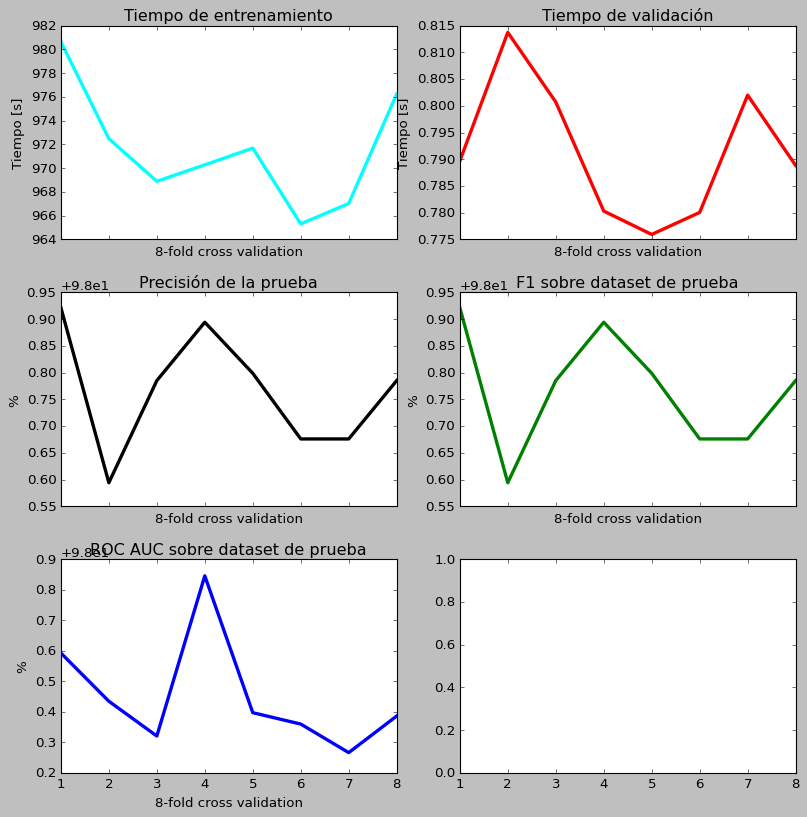

In [ ]:
plt.style.use('classic')
# Create subplots
fig, ax = plt.subplots(3, 2,figsize=(10,10), sharex=True)
fig.tight_layout(h_pad=3, w_pad=2)

ax[0][0].plot(cv,fit_time, linewidth=3, color='cyan')
ax[0][1].plot(cv,score_time, linewidth=3, color='red')
ax[1][0].plot(cv,test_accuracy, linewidth=3, color='black')
ax[1][1].plot(cv,test_f1_micro,linewidth=3, color='green')
ax[2][0].plot(cv,test_roc_auc,linewidth=3, color='blue')
#------1
ax[0][0].title.set_text('Tiempo de entrenamiento')
ax[0][0].set_xlabel('8-fold cross validation')
ax[0][0].set_ylabel('Tiempo [s]')
#------2
ax[0][1].title.set_text('Tiempo de validación')
ax[0][1].set_xlabel('8-fold cross validation')
ax[0][1].set_ylabel('Tiempo [s]')
#------3
ax[1][0].title.set_text('Precisión de la prueba')
ax[1][0].set_xlabel('8-fold cross validation')
ax[1][0].set_ylabel('%')
#------4
ax[1][1].title.set_text('F1 sobre dataset de prueba')
ax[1][1].set_xlabel('8-fold cross validation')
ax[1][1].set_ylabel('%')
#------5
ax[2][0].title.set_text('ROC AUC sobre dataset de prueba')
ax[2][0].set_xlabel('8-fold cross validation')
ax[2][0].set_ylabel('%')

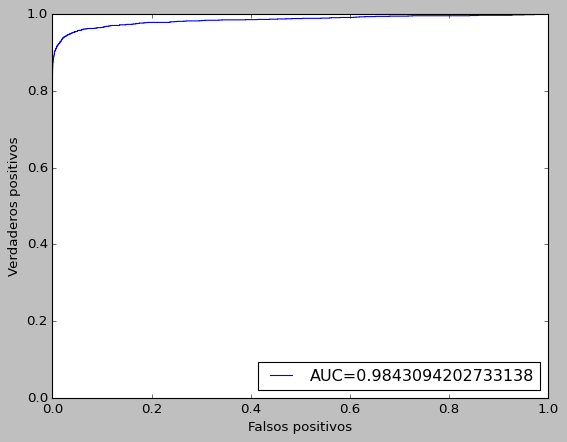

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

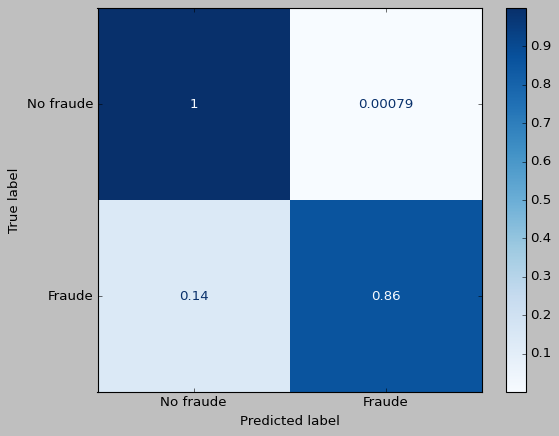

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['No fraude',
                                                          'Fraude'],
                     normalize='true', cmap='Blues');

In [20]:
# save model to file
pickle.dump(clf, open("xgb_n01.pickle.dat", "wb"))

# **6. GBM**

In [11]:
model1 = GradientBoostingClassifier(n_estimators=700,  max_depth=15, max_features='sqrt')
start_time = timer(None) 
model1.fit(X_train,y_train)
timer(start_time)


 Time taken: 0 hours 8 minutes and 28.57 seconds.


In [12]:
scoring = ['roc_auc', 'accuracy','f1_micro']

scores2 = cross_validate(model1, X_train, y_train, scoring=scoring, cv=8)

In [13]:
cv=range(1,9)
fit_time=scores2['fit_time']
score_time=scores2['score_time']
test_accuracy=[k*100 for k in scores2['test_accuracy']]
test_f1_micro=[k*100 for k in scores2['test_f1_micro']]
test_roc_auc=[k*100 for k in scores2['test_roc_auc']]
print(score_time)
print(fit_time)
print(test_accuracy)
print(test_f1_micro)
print(test_roc_auc)

[0.92609358 0.87422466 0.89959717 0.85534811 0.91932082 0.903368
 0.83318472 0.91896081]
[403.49252796 416.65967822 411.69793677 374.80288577 387.48287725
 348.01641536 359.97435951 391.5695951 ]
[98.33469833469833, 98.02074802074802, 98.14359814359814, 98.3073983073983, 98.17089817089817, 98.07534807534807, 98.0889980889981, 98.45754845754846]
[98.33469833469833, 98.02074802074802, 98.14359814359814, 98.3073983073983, 98.17089817089817, 98.07534807534807, 98.0889980889981, 98.45754845754846]
[98.42184526869211, 98.67942266590916, 98.28952826700575, 98.85917448980511, 98.26231637042447, 98.49608617626635, 98.18449079710341, 98.33563293022752]


Text(68.625, 0.5, '%')

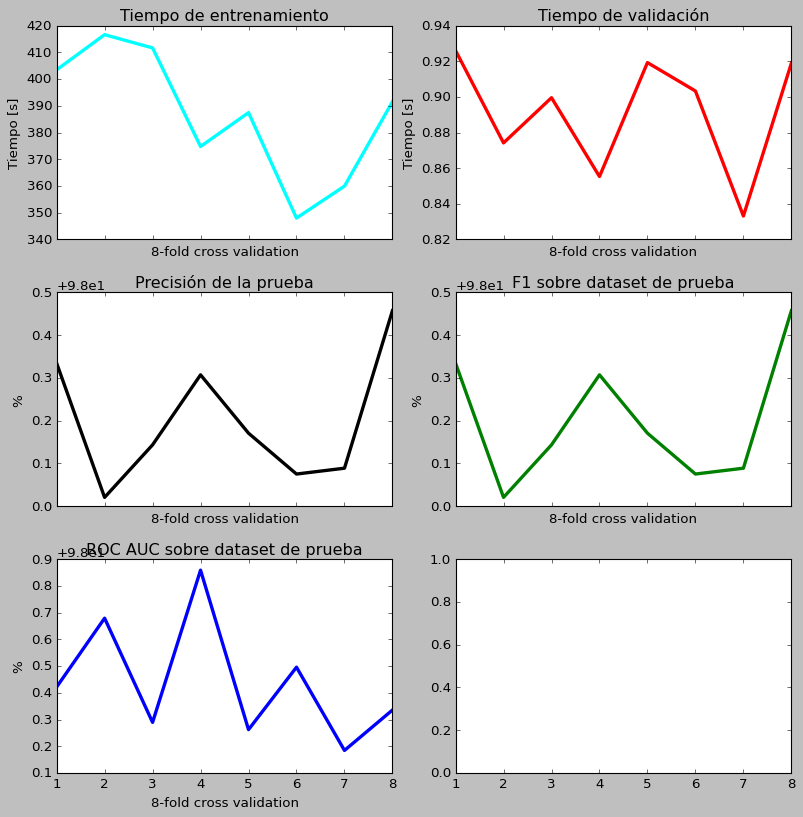

In [14]:
plt.style.use('classic')
# Create subplots
fig, ax = plt.subplots(3, 2,figsize=(10,10), sharex=True)
fig.tight_layout(h_pad=3, w_pad=2)

ax[0][0].plot(cv,fit_time, linewidth=3, color='cyan')
ax[0][1].plot(cv,score_time, linewidth=3, color='red')
ax[1][0].plot(cv,test_accuracy, linewidth=3, color='black')
ax[1][1].plot(cv,test_f1_micro,linewidth=3, color='green')
ax[2][0].plot(cv,test_roc_auc,linewidth=3, color='blue')
#------1
ax[0][0].title.set_text('Tiempo de entrenamiento')
ax[0][0].set_xlabel('8-fold cross validation')
ax[0][0].set_ylabel('Tiempo [s]')
#------2
ax[0][1].title.set_text('Tiempo de validación')
ax[0][1].set_xlabel('8-fold cross validation')
ax[0][1].set_ylabel('Tiempo [s]')
#------3
ax[1][0].title.set_text('Precisión de la prueba')
ax[1][0].set_xlabel('8-fold cross validation')
ax[1][0].set_ylabel('%')
#------4
ax[1][1].title.set_text('F1 sobre dataset de prueba')
ax[1][1].set_xlabel('8-fold cross validation')
ax[1][1].set_ylabel('%')
#------5
ax[2][0].title.set_text('ROC AUC sobre dataset de prueba')
ax[2][0].set_xlabel('8-fold cross validation')
ax[2][0].set_ylabel('%')

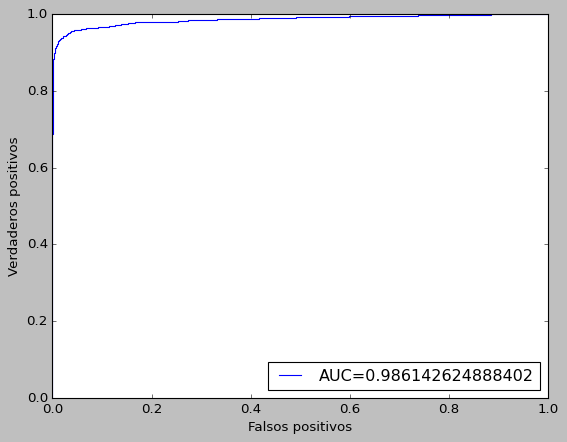

In [15]:
y_pred_proba = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

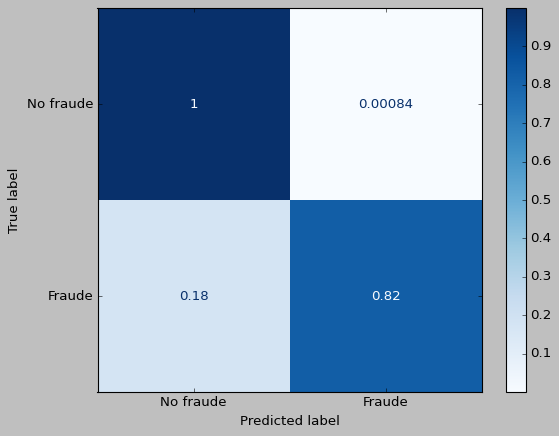

In [16]:
plot_confusion_matrix(model1, X_test, y_test, display_labels=['No fraude',
                                                          'Fraude'],
                     normalize='true', cmap='Blues');

As a final observation, although both the XGBoost and GradientBoosting models perform well with respect to the AUC_ROC metric, the correlation matrix shows that in both cases there is a certain percentage of misclassification of our label of interest (Fraud), with 14.0% and 18.0% false negatives respectively. However, this indicator shows a good classification, so it will be considered in the future to train new models. 

In [17]:
import pickle

In [18]:
# save model to file
pickle.dump(model1, open("gbm_n01.pickle.dat", "wb"))